In [1]:
import GPy
from dp4gp import datasets
df = datasets.load_citibike(station=None)
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

d = datetime.strptime(df.starttime[0],'%m/%d/%Y %H:%M:%S')
Ntesting = 1000
df = df.sample(10000)
df = df[2000:]
datasets.add_citibike_extra_columns(df)

def meanabserror(pred,act):
    return np.mean(np.abs(pred-act))

def rmserror(pred,act):
    return np.sqrt(np.mean((pred-act)**2))

def buildgrid(rawinputs,rawoutputs,N):
    """
    buildgrid(df,inputcols,outputcol,N)
        df        - dataframe
        inputcols - names of columns of df to use as inputs
        outputcol - name of column we're averaging into bins
        N         - list of number of boundaries for each dimension (should be same length as inputcols)
    """

    binmins = np.min(rawinputs,0)
    binmaxs = np.max(rawinputs,0)
    ranges = []
    for (ri,rmin,rmax,Ni) in zip(rawinputs.T,binmins,binmaxs,N): #loops through dimensions.
        ran = np.linspace(rmin,rmax,Ni)
        ranges.append(ran)


    currentinput = None
    for rang in ranges:
        newinput = np.c_[rang[1:],rang[:-1]]
        if currentinput is None:
            currentinput = newinput.copy()
        else:
            temp = newinput.copy()
            for i in range(len(currentinput)-1):
                temp = np.r_[temp,newinput]
            currentinput = np.c_[currentinput.repeat(len(newinput),0),temp]

    output = np.zeros(len(currentinput))
    outputcount = np.zeros(len(currentinput))
    for rin,rout in zip(rawinputs,rawoutputs):
        loc = [True]*len(currentinput)
        for dim in range(len(rin)):
            loc &= ((rin[dim]<currentinput[:,dim*2]) & (rin[dim]>currentinput[:,dim*2+1]))
        output[loc]+=rout
        outputcount[loc]+=1
    stepsizes = currentinput[0,0::2]-currentinput[0,1::2]
    return currentinput, output, outputcount, stepsizes, rawinputs, rawoutputs

inputcols = ['start station latitude','end station longitude','end station latitude','end station longitude']
outputcol = ['tripduration']

# strip out journeys over 2 hours.
df = df[df[outputcol].values<(3600*2)]
df = df[df['end station latitude']>=40.6]

results = {}
for Ntraining in [80,160,320,640,1280,2560]:
    for Nsteps in [2,3,4,5,6]:#,16]:
        #bestGnoise_simple = bestGnoises[(Ntraining,Nsteps)]['bestGnoise_simple']
        #bestGnoise_integral = bestGnoises[(Ntraining,Nsteps)]['bestGnoise_integral']
        for Gnoise in 0.1**np.arange(10):
            rawoutputs = df[outputcol].values[0:Ntraining,:]
            outmean = np.mean(rawoutputs)
            rawoutputs = rawoutputs - outmean
            areainputs,outputs,outputcounts,stepsizes, rins, routs = buildgrid(df[inputcols].values[0:Ntraining,:], rawoutputs, [Nsteps,Nsteps,Nsteps,Nsteps])

            #get rid of empty tiles (these won't tell us much)
            keep = outputcounts>0
            areainputs = areainputs[keep,:]
            outputs = outputs[keep]
            outputcounts = outputcounts[keep]
            #get into units of density
            out = (outputs/outputcounts)[:,None]*np.prod(stepsizes)
            #!!! SCALE TO TENTHS OF DEGREES RATHER THAN DEGREES!
            areainputs*=10
            out*=10**4


            kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=areainputs.shape[1],lengthscale=[1,1,1,1],variances=[1])
            m = GPy.models.GPRegression(areainputs,out,kernel,normalizer=None)
            sel = (areainputs[:,4]>407.4) & (areainputs[:,4]<407.6) & (areainputs[:,6]>-739.7) & (areainputs[:,6]<-739.6)
            centroidinputs = (areainputs[:,::2]+areainputs[:,1::2])/2
            kernel_simple = GPy.kern.RBF(input_dim=centroidinputs.shape[1],lengthscale=1,variance=1,ARD=False)
            m_simple = GPy.models.GPRegression(centroidinputs,out,kernel_simple,normalizer=False)

            testn = 1000
            teststart = 3000
            testX = np.zeros([testn,8])
            testX[:,0::2] = 10*df[inputcols].values[teststart:(teststart+testn),:]
            testX_simple = 10*df[inputcols].values[teststart:(teststart+testn),:]
            testY = df[outputcol].values[teststart:(teststart+testn),:]

            print(Ntraining,Nsteps,Gnoise)
            ##################################################
            #2980.9579870417283, 0.14956861922263512, 2.0611536224385579e-09
            #numbers from separate grid search
            m.integral.variance = 2980.957
            m.integral.lengthscale = 0.149
            #m.Gaussian_noise = 2.061e-09

            m_simple.kern.variance = 0.00012340980408667956
            m_simple.kern.lengthscale = 0.149
            #m_simple.Gaussian_noise = 4.1399377187851668e-08

            m.integral.variances.fix(2980.957)
            m.integral.lengthscale.fix(0.149)
            #m.Gaussian_noise.fix(2.061e-09)
            m.Gaussian_noise.fix(Gnoise)
            #m.Gaussian_noise.fix(bestGnoise_integral)
            m_simple.kern.variance.fix(0.00012340980408667956)
            m_simple.kern.lengthscale.fix(0.149)
            #m_simple.Gaussian_noise.fix(4.1399377187851668e-08)
            m_simple.Gaussian_noise.fix(Gnoise)
            #m_simple.Gaussian_noise.fix(bestGnoise_simple)
            #m_simple.optimize()
            means_simple, _ = m_simple.predict_noiseless(testX_simple)

            preds = means_simple/(10**4)/np.prod(stepsizes)+outmean
            mae_simple = meanabserror(preds,testY)
            rmse_simple = rmserror(preds,testY)
            print("Simple Method: %0.2f, %0.2f" % (mae_simple,rmse_simple))


            #m.optimize()
            #print(m_simple.Gaussian_noise,m.Gaussian_noise)
            means, _ = m.predict_noiseless(testX)
            preds = means+outmean
            mae_integral = meanabserror(preds,testY)
            rmse_integral = rmserror(preds,testY)
            print("Integral Method: %0.2f, %0.2f" % (mae_integral,rmse_integral))
            results[(Ntraining,Nsteps,Gnoise)] = {'mae_integral':mae_integral, 'mae_simple':mae_simple,'rmse_integral':rmse_integral, 'rmse_simple':rmse_simple}
            #results[(Ntraining,Nsteps)] = {'mae_integral':mae_integral, 'mae_simple':mae_simple,'rmse_integral':rmse_integral, 'rmse_simple':rmse_simple}

80 2 1.0
Simple Method: 506.76, 650.42
Integral Method: 500.18, 646.80
80 2 0.1
Simple Method: 506.76, 650.42
Integral Method: 498.77, 646.05
80 2 0.010000000000000002
Simple Method: 506.74, 650.40
Integral Method: 498.59, 645.95
80 2 0.0010000000000000002
Simple Method: 506.57, 650.28
Integral Method: 498.57, 645.94
80 2 0.00010000000000000002
Simple Method: 505.78, 649.71
Integral Method: 498.57, 645.94
80 2 1.0000000000000003e-05
Simple Method: 505.11, 649.24
Integral Method: 498.57, 645.94
80 2 1.0000000000000004e-06
Simple Method: 504.99, 649.16
Integral Method: 498.57, 645.94
80 2 1.0000000000000004e-07
Simple Method: 504.98, 649.15
Integral Method: 498.57, 645.94
80 2 1.0000000000000005e-08
Simple Method: 504.98, 649.15
Integral Method: 498.57, 645.94
80 2 1.0000000000000005e-09
Simple Method: 504.98, 649.15
Integral Method: 498.57, 645.94
80 3 1.0
Simple Method: 506.76, 650.42
Integral Method: 511.22, 656.56
80 3 0.1
Simple Method: 506.77, 650.43
Integral Method: 546.71, 717.79

Simple Method: 438.81, 633.42
Integral Method: 470.67, 676.94
160 6 1.0000000000000004e-06
Simple Method: 442.99, 640.17
Integral Method: 472.57, 679.07
160 6 1.0000000000000004e-07
Simple Method: 443.65, 641.13
Integral Method: 472.77, 679.30
160 6 1.0000000000000005e-08
Simple Method: 443.72, 641.24
Integral Method: 472.79, 679.32
160 6 1.0000000000000005e-09
Simple Method: 443.72, 641.25
Integral Method: 472.79, 679.32
320 2 1.0
Simple Method: 482.90, 641.60
Integral Method: 483.02, 641.64
320 2 0.1
Simple Method: 482.90, 641.60
Integral Method: 483.03, 641.65
320 2 0.010000000000000002
Simple Method: 482.90, 641.60
Integral Method: 483.04, 641.65
320 2 0.0010000000000000002
Simple Method: 482.90, 641.61
Integral Method: 483.04, 641.65
320 2 0.00010000000000000002
Simple Method: 482.92, 641.61
Integral Method: 483.04, 641.65
320 2 1.0000000000000003e-05
Simple Method: 482.93, 641.62
Integral Method: 483.04, 641.65
320 2 1.0000000000000004e-06
Simple Method: 482.93, 641.62
Integral M

Integral Method: 376.90, 567.98
640 6 1.0
Simple Method: 477.84, 640.39
Integral Method: 477.53, 640.05
640 6 0.1
Simple Method: 477.67, 640.15
Integral Method: 474.62, 636.84
640 6 0.010000000000000002
Simple Method: 476.00, 637.82
Integral Method: 448.94, 611.77
640 6 0.0010000000000000002
Simple Method: 458.89, 618.60
Integral Method: 379.80, 563.55
640 6 0.00010000000000000002
Simple Method: 395.05, 566.85
Integral Method: 388.78, 585.54
640 6 1.0000000000000003e-05
Simple Method: 376.27, 561.51
Integral Method: 399.42, 596.30
640 6 1.0000000000000004e-06
Simple Method: 379.54, 565.89
Integral Method: 400.78, 597.67
640 6 1.0000000000000004e-07
Simple Method: 380.20, 566.62
Integral Method: 400.91, 597.81
640 6 1.0000000000000005e-08
Simple Method: 380.28, 566.69
Integral Method: 400.93, 597.82
640 6 1.0000000000000005e-09
Simple Method: 380.28, 566.70
Integral Method: 400.93, 597.82
1280 2 1.0
Simple Method: 480.54, 641.01
Integral Method: 479.59, 640.71
1280 2 0.1
Simple Method: 

Simple Method: 458.91, 622.14
Integral Method: 344.11, 541.00
2560 5 0.00010000000000000002
Simple Method: 399.08, 566.84
Integral Method: 348.15, 546.65
2560 5 1.0000000000000003e-05
Simple Method: 360.82, 541.22
Integral Method: 348.86, 547.46
2560 5 1.0000000000000004e-06
Simple Method: 356.16, 538.75
Integral Method: 348.93, 547.54
2560 5 1.0000000000000004e-07
Simple Method: 355.69, 538.52
Integral Method: 348.94, 547.55
2560 5 1.0000000000000005e-08
Simple Method: 355.64, 538.50
Integral Method: 348.94, 547.55
2560 5 1.0000000000000005e-09
Simple Method: 355.64, 538.49
Integral Method: 348.94, 547.55
2560 6 1.0
Simple Method: 472.37, 639.48
Integral Method: 471.75, 638.73
2560 6 0.1
Simple Method: 472.16, 639.15
Integral Method: 466.14, 631.99
2560 6 0.010000000000000002
Simple Method: 470.13, 636.01
Integral Method: 421.97, 587.49
2560 6 0.0010000000000000002
Simple Method: 450.06, 611.24
Integral Method: 347.83, 544.33
2560 6 0.00010000000000000002
Simple Method: 377.82, 550.30

In [2]:
import pickle
pickle.dump(results,open('citibike_cached_results_search_noise_param.p','wb'))

In [3]:
bestGnoises = {}
for Ntraining in [80,160,320,640,1280,2560]:
    for Nsteps in [2,3,4,5,6]:#,16]:
        best_int = np.inf
        best_simple = np.inf
        bestGnoise_integral = np.nan
        for Gnoise in 0.1**np.arange(10):
            mae_int = results[(Ntraining,Nsteps,Gnoise)]['mae_integral']
            if mae_int<best_int:
                best_int = mae_int
                bestGnoise_integral = Gnoise
                
            mae_simple = results[(Ntraining,Nsteps,Gnoise)]['mae_simple']
            if mae_simple<best_simple:
                best_simple = mae_simple
                bestGnoise_simple = Gnoise
        bestGnoises[(Ntraining,Nsteps)] = {'bestGnoise_simple':bestGnoise_simple,'bestGnoise_integral':bestGnoise_integral}
        #print("%4d %4d %4d %4d %0.2f %0.2f" % (Ntraining,Nsteps,np.log10(bestGnoise_integral),np.log10(bestGnoise_simple),best_int,best_simple))
        #print("%0.3d & %0.3f & " % (best_int,best_simple))

In [4]:
bestGnoises

{(80, 2): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 1.0000000000000005e-09},
 (80, 3): {'bestGnoise_simple': 1.0, 'bestGnoise_integral': 1.0},
 (80, 4): {'bestGnoise_simple': 0.0010000000000000002,
  'bestGnoise_integral': 0.1},
 (80, 5): {'bestGnoise_simple': 0.0010000000000000002,
  'bestGnoise_integral': 0.010000000000000002},
 (80, 6): {'bestGnoise_simple': 0.0010000000000000002,
  'bestGnoise_integral': 0.010000000000000002},
 (160, 2): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 1.0000000000000005e-09},
 (160, 3): {'bestGnoise_simple': 1.0000000000000003e-05,
  'bestGnoise_integral': 1.0},
 (160, 4): {'bestGnoise_simple': 0.00010000000000000002,
  'bestGnoise_integral': 0.1},
 (160, 5): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 0.0010000000000000002},
 (160, 6): {'bestGnoise_simple': 0.00010000000000000002,
  'bestGnoise_integral': 0.0010000000000000002},
 (320, 2): {'bestGnoise_simple': 1.0, 'be

In [5]:
import GPy
from dp4gp import datasets
df = datasets.load_citibike(station=None)
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

d = datetime.strptime(df.starttime[0],'%m/%d/%Y %H:%M:%S')
Ntesting = 1000
df = df.sample(10000)
df = df[2000:]
datasets.add_citibike_extra_columns(df)

def meanabserror(pred,act):
    return np.mean(np.abs(pred-act))

def rmserror(pred,act):
    return np.sqrt(np.mean((pred-act)**2))

def buildgrid(rawinputs,rawoutputs,N):
    """
    buildgrid(df,inputcols,outputcol,N)
        df        - dataframe
        inputcols - names of columns of df to use as inputs
        outputcol - name of column we're averaging into bins
        N         - list of number of boundaries for each dimension (should be same length as inputcols)
    """

    binmins = np.min(rawinputs,0)
    binmaxs = np.max(rawinputs,0)
    ranges = []
    for (ri,rmin,rmax,Ni) in zip(rawinputs.T,binmins,binmaxs,N): #loops through dimensions.
        ran = np.linspace(rmin,rmax,Ni)
        ranges.append(ran)


    currentinput = None
    for rang in ranges:
        newinput = np.c_[rang[1:],rang[:-1]]
        if currentinput is None:
            currentinput = newinput.copy()
        else:
            temp = newinput.copy()
            for i in range(len(currentinput)-1):
                temp = np.r_[temp,newinput]
            currentinput = np.c_[currentinput.repeat(len(newinput),0),temp]

    output = np.zeros(len(currentinput))
    outputcount = np.zeros(len(currentinput))
    for rin,rout in zip(rawinputs,rawoutputs):
        loc = [True]*len(currentinput)
        for dim in range(len(rin)):
            loc &= ((rin[dim]<currentinput[:,dim*2]) & (rin[dim]>currentinput[:,dim*2+1]))
        output[loc]+=rout
        outputcount[loc]+=1
    stepsizes = currentinput[0,0::2]-currentinput[0,1::2]
    return currentinput, output, outputcount, stepsizes, rawinputs, rawoutputs

inputcols = ['start station latitude','end station longitude','end station latitude','end station longitude']
outputcol = ['tripduration']

# strip out journeys over 2 hours.
df = df[df[outputcol].values<(3600*2)]
df = df[df['end station latitude']>=40.6]

results = {}
for Ntraining in [80,160,320,640,1280,2560]:
    for Nsteps in [2,3,4,5,6]:#,16]:
        bestGnoise_simple = bestGnoises[(Ntraining,Nsteps)]['bestGnoise_simple']
        bestGnoise_integral = bestGnoises[(Ntraining,Nsteps)]['bestGnoise_integral']
        #for Gnoise in 0.1**np.arange(10):
        rawoutputs = df[outputcol].values[0:Ntraining,:]
        outmean = np.mean(rawoutputs)
        rawoutputs = rawoutputs - outmean
        areainputs,outputs,outputcounts,stepsizes, rins, routs = buildgrid(df[inputcols].values[0:Ntraining,:], rawoutputs, [Nsteps,Nsteps,Nsteps,Nsteps])

        #get rid of empty tiles (these won't tell us much)
        keep = outputcounts>0
        areainputs = areainputs[keep,:]
        outputs = outputs[keep]
        outputcounts = outputcounts[keep]
        #get into units of density
        out = (outputs/outputcounts)[:,None]*np.prod(stepsizes)
        #!!! SCALE TO TENTHS OF DEGREES RATHER THAN DEGREES!
        areainputs*=10
        out*=10**4


        kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=areainputs.shape[1],lengthscale=[1,1,1,1],variances=[1])
        m = GPy.models.GPRegression(areainputs,out,kernel,normalizer=None)
        sel = (areainputs[:,4]>407.4) & (areainputs[:,4]<407.6) & (areainputs[:,6]>-739.7) & (areainputs[:,6]<-739.6)
        centroidinputs = (areainputs[:,::2]+areainputs[:,1::2])/2
        kernel_simple = GPy.kern.RBF(input_dim=centroidinputs.shape[1],lengthscale=1,variance=1,ARD=False)
        m_simple = GPy.models.GPRegression(centroidinputs,out,kernel_simple,normalizer=False)

        testn = 1000
        teststart = 4000
        testX = np.zeros([testn,8])
        testX[:,0::2] = 10*df[inputcols].values[teststart:(teststart+testn),:]
        testX_simple = 10*df[inputcols].values[teststart:(teststart+testn),:]
        testY = df[outputcol].values[teststart:(teststart+testn),:]

        print(Ntraining,Nsteps,Gnoise)
        ##################################################
        #2980.9579870417283, 0.14956861922263512, 2.0611536224385579e-09
        #numbers from separate grid search
        m.integral.variance = 2980.957
        m.integral.lengthscale = 0.149
        #m.Gaussian_noise = 2.061e-09

        m_simple.kern.variance = 0.00012340980408667956
        m_simple.kern.lengthscale = 0.149
        #m_simple.Gaussian_noise = 4.1399377187851668e-08

        m.integral.variances.fix(2980.957)
        m.integral.lengthscale.fix(0.149)
        #m.Gaussian_noise.fix(2.061e-09)
        #m.Gaussian_noise.fix(Gnoise)
        m.Gaussian_noise.fix(bestGnoise_integral)
        m_simple.kern.variance.fix(0.00012340980408667956)
        m_simple.kern.lengthscale.fix(0.149)
        #m_simple.Gaussian_noise.fix(4.1399377187851668e-08)
        #m_simple.Gaussian_noise.fix(Gnoise)
        m_simple.Gaussian_noise.fix(bestGnoise_simple)
        #m_simple.optimize()
        means_simple, _ = m_simple.predict_noiseless(testX_simple)

        preds = means_simple/(10**4)/np.prod(stepsizes)+outmean
        mae_simple = meanabserror(preds,testY)
        rmse_simple = rmserror(preds,testY)
        print("Simple Method: %0.2f, %0.2f" % (mae_simple,rmse_simple))


        #m.optimize()
        #print(m_simple.Gaussian_noise,m.Gaussian_noise)
        means, _ = m.predict_noiseless(testX)
        preds = means+outmean
        mae_integral = meanabserror(preds,testY)
        rmse_integral = rmserror(preds,testY)
        print("Integral Method: %0.2f, %0.2f" % (mae_integral,rmse_integral))
        #results[(Ntraining,Nsteps,Gnoise)] = {'mae_integral':mae_integral, 'mae_simple':mae_simple,'rmse_integral':rmse_integral, 'rmse_simple':rmse_simple}
        results[(Ntraining,Nsteps)] = {'mae_integral':mae_integral, 'mae_simple':mae_simple,'rmse_integral':rmse_integral, 'rmse_simple':rmse_simple}

80 2 1.0000000000000005e-09
Simple Method: 487.36, 622.95
Integral Method: 465.06, 614.89
80 3 1.0000000000000005e-09
Simple Method: 494.94, 628.69
Integral Method: 482.78, 620.44
80 4 1.0000000000000005e-09
Simple Method: 485.89, 621.35
Integral Method: 469.86, 609.61
80 5 1.0000000000000005e-09
Simple Method: 478.52, 617.39
Integral Method: 452.83, 604.06
80 6 1.0000000000000005e-09
Simple Method: 471.32, 611.52
Integral Method: 474.74, 613.72
160 2 1.0000000000000005e-09
Simple Method: 487.40, 623.88
Integral Method: 475.55, 618.91
160 3 1.0000000000000005e-09
Simple Method: 471.09, 612.60
Integral Method: 481.60, 619.78
160 4 1.0000000000000005e-09
Simple Method: 451.01, 597.88
Integral Method: 464.25, 606.04
160 5 1.0000000000000005e-09
Simple Method: 425.55, 625.62
Integral Method: 435.73, 655.30
160 6 1.0000000000000005e-09
Simple Method: 406.92, 575.38
Integral Method: 408.94, 584.48
320 2 1.0000000000000005e-09
Simple Method: 473.13, 619.52
Integral Method: 466.20, 617.37
320 

In [7]:
#import pickle
#pickle.dump(results,open('citibike_results_done.p','wb'))

In [27]:
stepchoices = [2,3,4,5,6]
print("\\begin{tabular}{l %s}\\\\" % ("r "*(len(stepchoices)*2)))
print("\\hline")
print(" & \multicolumn{%d}{c}{Number of bins}" % (len(stepchoices)*2),end="")
print("\\\\")
#print(" & ",end="")
for Nsteps in stepchoices:
    print(" & \multicolumn{2}{c}{$%d^4$} " % Nsteps,end="")
print("\\\\")  

print("Samples ",end="")
for Nsteps in stepchoices:
    print(" & Centroid & Integral ",end="")
print("\\\\")
print("\\hline")

for Ntraining in [80,160,320,640,1280,2560]:
    print("%d " % Ntraining,end="")
    for Nsteps in stepchoices:
        res = results[(Ntraining,Nsteps)]
        sres = res['mae_simple']
        ires = res['mae_integral']
        #sres = res['rmse_simple']
        #ires = res['rmse_integral']
        sbest=ibest=""
        if sres<ires:
            sbest = '\\textbf'
        else:
            ibest = '\\textbf'
        
        print("& %s{%0.1f} & %s{%0.1f} " % (sbest,sres,ibest,ires),end="")
    print("\\\\")
print("\\hline")
print("\\end{tabular}")


\begin{tabular}{l r r r r r r r r r r }\\
\hline
 & \multicolumn{10}{c}{Number of bins}\\
 & \multicolumn{2}{c}{$2^4$}  & \multicolumn{2}{c}{$3^4$}  & \multicolumn{2}{c}{$4^4$}  & \multicolumn{2}{c}{$5^4$}  & \multicolumn{2}{c}{$6^4$} \\
Samples  & Centroid & Integral  & Centroid & Integral  & Centroid & Integral  & Centroid & Integral  & Centroid & Integral \\
\hline
80 & {487.4} & \textbf{465.1} & {494.9} & \textbf{482.8} & {485.9} & \textbf{469.9} & {478.5} & \textbf{452.8} & \textbf{471.3} & {474.7} \\
160 & {487.4} & \textbf{475.5} & \textbf{471.1} & {481.6} & \textbf{451.0} & {464.2} & \textbf{425.5} & {435.7} & \textbf{406.9} & {408.9} \\
320 & {473.1} & \textbf{466.2} & {453.4} & \textbf{438.3} & {422.4} & \textbf{388.9} & \textbf{408.9} & {431.9} & {378.8} & \textbf{374.0} \\
640 & {468.6} & \textbf{465.5} & {449.5} & \textbf{435.5} & {413.4} & \textbf{374.7} & \textbf{372.5} & {379.9} & {366.7} & \textbf{365.2} \\
1280 & {469.8} & \textbf{467.5} & {450.7} & \textbf{446.3} & {

In [ ]:
debug

> <ipython-input-52-9ed2d4efe13d>(70)<module>()
     68 for Ntraining in [80,160,320,640,1280,2560]:
     69     for Nsteps in [2,3,4,5,6]:#,16]:
---> 70         bestGnoise_simple = bestGnoises[(Ntraining,Nsteps)]['bestGnoise_simple']
     71         bestGnoise_integral = bestGnoises[(Ntraining,Nsteps)]['bestGnoise_integral']
     72         #for Gnoise in 0.1**np.arange(10):

ipdb> (Ntraining,Nsteps)
(80, 2)
ipdb> bestGnoises
{(160, 2): {'bestGnoise_simple': 1.0, 'bestGnoise_integral': 1.0}, (160, 3): {'bestGnoise_simple': 1.0000000000000005e-09, 'bestGnoise_integral': 0.1}, (160, 4): {'bestGnoise_simple': 1.0000000000000005e-09, 'bestGnoise_integral': 0.010000000000000002}, (160, 5): {'bestGnoise_simple': 1.0000000000000003e-05, 'bestGnoise_integral': 0.0010000000000000002}, (160, 6): {'bestGnoise_simple': 0.00010000000000000002, 'bestGnoise_integral': 0.010000000000000002}, (320, 2): {'bestGnoise_simple': 1.0000000000000005e-09, 'bestGnoise_integral': 1.0000000000000005e-09}, (320, 

In [ ]:
import pickle
pickle.dump(results,open('citibike_cached_results_done.p','wb'))

In [ ]:
print("\\begin{tabular}{l r r r r r r r r }\n\\hline\n")
print(" & \\multicolumn{8}{c}{Number of bins}\\\\\n")
for Nsteps in [2,3,4,5,6]:
print(" & \\multicolumn{2}{c}{$\{2^4\}$} & \multicolumn{2}{c}{${4^4}$} & \multicolumn{2}{c}{${7^4}$} & \multicolumn{2}{c}{${15^4}$}\\
Samples & centroid & integral & centroid & integral & centroid & integral & centroid & integral\\
\hline
160 & 636.0 & 636.4 & 619.7 & 640.5 & 663.1 & 624.1 & 1704.6 & 632.8\\
320 & 635.0 & 634.9 & 600.4 & 614.5 & 635.6 & 610.9 & 2416.1 & 629.0\\
640 & 635.8 & 635.3 & 590.0 & 581.4 & 627.7 & 591.8 & 1139.9 & 623.1\\
1280 & 636.0 & 635.5 & 589.8 & 571.4 & 610.6 & 602.8 & 793.9 & 606.5\\
2560 & 635.5 & 635.4 & 587.5 & 572.4 & 622.8 & 617.7 & 738.2 & 598.4\\
\hline
\end{tabular}


for Ntraining in [160,320,640,1280,2560]:
    for Nsteps in [2,3,6,8]:
        results[(Ntraining,Nsteps)]['mae_integral']
        = {'mae_integral':mae_integral, 'mae_simple':mae_simple,'rmse_integral':rmse_integral, 'rmse_simple':rmse_simple}

In [37]:
bestGnoises

{(160, 2): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 1.0000000000000005e-09},
 (160, 3): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 0.1},
 (160, 6): {'bestGnoise_simple': 0.00010000000000000002,
  'bestGnoise_integral': 0.0010000000000000002},
 (160, 8): {'bestGnoise_simple': 0.00010000000000000002,
  'bestGnoise_integral': 0.00010000000000000002},
 (320, 2): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 1.0000000000000005e-09},
 (320, 3): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 0.1},
 (320, 6): {'bestGnoise_simple': 1.0000000000000003e-05,
  'bestGnoise_integral': 0.0010000000000000002},
 (320, 8): {'bestGnoise_simple': 0.00010000000000000002,
  'bestGnoise_integral': 0.00010000000000000002},
 (640, 2): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integral': 1.0000000000000005e-09},
 (640, 3): {'bestGnoise_simple': 1.0000000000000005e-09,
  'bestGnoise_integr

In [31]:
np.log10(Nsteps,bestGnoise_integral

TypeError: return arrays must be of ArrayType

In [15]:
np.max(m.X,0)-np.min(m.X,0)

array([0.89055223, 0.89055222, 0.66304325, 0.66304325, 0.84695917,
       0.84695917, 0.66304325, 0.66304325])

In [17]:
np.std(m.Y)

0.36158650414558463

In [18]:
np.std(m_simple.Y)

0.36158650414558463

In [2]:
import pickle
pickle.dump(results,open('finalresults.p','wb'))
#results = pickle.load(open('finalresults.p','rb'))
#results

EOFError: Ran out of input

In [11]:
results

{(160, 2): {'integral': 473.48872468039559, 'simple': 477.72949068621944},
 (160, 4): {'integral': 418.75469628358348, 'simple': 445.74799681813386},
 (160, 8): {'integral': 419.89815847543611, 'simple': 445.8285853632608},
 (320, 2): {'integral': 482.46054840888877, 'simple': 486.82382867443602},
 (320, 4): {'integral': 412.78991896993097, 'simple': 438.93183074759713},
 (320, 8): {'integral': 423.13562373601911, 'simple': 464.51652161396777}}

In [35]:
Ntrainingoptions = [160,320]#,640,1280,2560]
Nstepsoptions = [2,4,8]#,16]

print("\\begin{tabular}{ c c c }")
print(" & ", end="")
for Ntraining in Ntrainingoptions:
    print("%0.2f" % Ntraining,end="")
    if Ntraining!=Ntrainingoptions[-1]:
        print(" & ",end="")
print("\\\\\n\\hline")
for Nsteps in Nstepsoptions:
    print("%0.2f & " % Nsteps,end="")
    for Ntraining in Ntrainingoptions:
        print("%0.2f" % results[(Ntraining,Nsteps)]['integral'],end="")
        if Ntraining!=Ntrainingoptions[-1]:
            print(" & ",end="")
    print("\\\\")
print("\\hline \n\\end{tabular}")

\begin{tabular}{ c c c }
 & 160.00 & 320.00\\
\hline
2.00 & 473.49 & 482.46\\
4.00 & 418.75 & 412.79\\
8.00 & 419.90 & 423.14\\
\hline 
\end{tabular}


\begin{tabular}{ |c|c|c| } 
 \hline
 cell1 & cell2 & cell3 \\ 
 cell4 & cell5 & cell6 \\ 
 cell7 & cell8 & cell9 \\ 
 \hline
\end{tabular}




In [128]:
##################################################
#2980.9579870417283, 0.14956861922263512, 2.0611536224385579e-09
#numbers from separate grid search
m.integral.variance = 2980.957
m.integral.lengthscale = 0.149#0.223 #0.149
m.Gaussian_noise = 2.061e-09
m_simple.kern.variance = 0.00012340980408667956
m_simple.kern.lengthscale = 0.149#0.22313016014842982
m_simple.Gaussian_noise = 4.1399377187851668e-08

#m_simple.optimize()
means_simple, _ = m_simple.predict_noiseless(testX_simple)

preds = means_simple/(10**4)/np.prod(stepsizes)+outmean
print("Simple Method: %0.2f" % meanabserror(preds,testY))

#m.optimize()
means, _ = m.predict_noiseless(testX)
preds = means+outmean
print("Integral Method: %0.2f" % meanabserror(preds,testY))

#400 points
#3x3x3x3->484/489
#9x9x9x9->593/392
#9x9x9x9=>480/387 (shorter lengthscale)

Simple Method: 480.87
Integral Method: 387.93


In [82]:
np.set_printoptions(suppress=True,precision=4)

In [83]:
var_options = np.exp(np.arange(8,16,1.5))
lengthscale_options = np.exp(np.arange(-4,0.5,0.7))
noise_options = np.exp(np.arange(-20,7,4))

results_m = {}
for var in var_options:
    for ls in lengthscale_options:
        for noise in noise_options:
            m.kern.variance = var
            m.kern.lengthscale = ls
            m.Gaussian_noise = noise
            means, _ = m.predict_noiseless(testX)
            preds = means+outmean
            mae = meanabserror(preds,testY)
            results_m[(var,ls,noise)] = {'predmeans':preds, 'mae':mae}

 /home/mike/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning:Mean of empty slice.
 /home/mike/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:invalid value encountered in double_scalars


In [85]:
#import pickle
#pickle.dump(results_m,open('results_m.p','wb'))

457.228000294
461.342039341
461.79072258
461.79968746
461.799851931
461.799854944
461.799854999
414.418868591
456.034945555
461.682531295
461.797701758
461.799815561
461.799854278
461.799854987
318.40148376
417.846252106
460.736008614
461.78026972
461.799496249
461.799848429
461.79985488
287.663466412
347.7045577
457.439330259
461.719900677
461.798390589
461.799828178
461.799854509
292.488546244
343.744971845
471.003642269
462.063052774
461.804729205
461.799944292
461.799856635
343.293769941
437.889847485
529.089860218
463.889125538
461.838867884
461.800569801
461.799868092
446.676493559
581.159489273
557.449967824
465.742533387
461.872806106
461.801191994
461.799879488
457.228000294
461.342039341
461.79072258
461.79968746
461.799851931
461.799854944
461.799854999
414.418868591
456.034945555
461.682531295
461.797701758
461.799815561
461.799854278
461.799854987
318.40148376
417.846252106
460.736008614
461.78026972
461.799496249
461.799848429
461.79985488
287.663466412
347.7045577
457.43

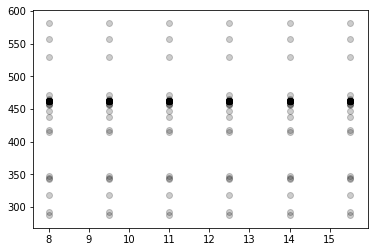

In [93]:
lowest = np.Inf
best_result = None
for res in results_m:
    preds = results_m[res]['predmeans']
    mae = meanabserror(preds,testY)
    print(mae)
    if mae<lowest:
        lowest = mae
        best_result = res
    plt.scatter(np.log(res[0]),mae,alpha=0.2,color='k')
print(best_result)

In [95]:
best_result, lowest

((2980.9579870417283, 0.14956861922263512, 2.0611536224385579e-09),
 287.66346641233753)

In [63]:
var_options = np.exp(np.arange(-9,0,1))
lengthscale_options = np.exp(np.arange(-4,1,0.5))
noise_options = np.exp(np.arange(-20,7,3))

results_msimple = {}
for var in var_options:
    print(".",end="")
    for ls in lengthscale_options:
        for noise in noise_options:
            m_simple.kern.variance = var
            m_simple.kern.lengthscale = ls
            m_simple.Gaussian_noise = noise
            means_simple, _ = m_simple.predict_noiseless(testX_simple)
            preds = means_simple/(10**4)/np.prod(stepsizes)+outmean
            results_msimple[(var,ls,noise)] = {'predmeans':preds, 'mae':meanabserror(preds,testY)}

.........

In [96]:
lowest = np.Inf
best_result = None
for res in results_msimple:
    if results_msimple[res]['mae']<lowest:
        lowest = results_msimple[res]['mae']
        best_result = res
    #plt.scatter(np.log(res[2]),results_msimple[res]['mae'],alpha=0.2,color='k')

In [97]:
best_result, lowest

((0.00012340980408667956, 0.22313016014842982, 4.1399377187851668e-08),
 283.70782877228783)

In [40]:
np.log(0.00555)

-5.1939573512237942

In [48]:
m_simple.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.34086819,+ve,
[1],3.48614709,+ve,
[2],0.30648994,+ve,
[3],3.48614709,+ve,
